# ===============================================================================
* NOTEBOOK 3 : ACP (ANALYSE EN COMPOSANTES PRINCIPALES)
* Projet : Modèle de prévision de l'occupation des stades
# ===============================================================================

In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage

In [39]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

# 1. CHARGEMENT DES DONNÉES

In [40]:
print("\n[1] CHARGEMENT DES DONNÉES")
print("-"*80)

df = pd.read_csv('../data/processed/data_cleaned.csv')

print(f"✓ Données chargées avec succès")
print(f"  - Lignes : {df.shape[0]}")
print(f"  - Colonnes : {df.shape[1]}")


[1] CHARGEMENT DES DONNÉES
--------------------------------------------------------------------------------
✓ Données chargées avec succès
  - Lignes : 363
  - Colonnes : 30


# 2. SÉLECTION DES VARIABLES POUR L'ACP

In [41]:
print("\n[2] SÉLECTION DES VARIABLES POUR L'ACP")
print("-"*80)

# Sélection des variables numériques pertinentes
# On exclut la variable cible (affluence_moyenne) et les variables dérivées
variables_acp = [
    'Capacite',
    'prix_billet_moyen',
    'temperature',
    'Recette_Moyenne',
    'isDerby',
    'is_important_match',
    'is_top_team_home',
    'est_weekend',
    'mois',
    'jour_semaine',
    'derby_top_team'
]

# Vérifier que toutes les variables existent
variables_acp = [var for var in variables_acp if var in df.columns]

print(f"\nVariables sélectionnées pour l'ACP ({len(variables_acp)}) :")
for i, var in enumerate(variables_acp, 1):
    print(f"  {i}. {var}")

# Création du dataframe pour l'ACP
df_acp = df[variables_acp].copy()

# Conversion des booléens en numériques
for col in df_acp.columns:
    if df_acp[col].dtype == 'bool':
        df_acp[col] = df_acp[col].astype(int)

print(f"\n✓ DataFrame ACP créé : {df_acp.shape}")



[2] SÉLECTION DES VARIABLES POUR L'ACP
--------------------------------------------------------------------------------

Variables sélectionnées pour l'ACP (11) :
  1. Capacite
  2. prix_billet_moyen
  3. temperature
  4. Recette_Moyenne
  5. isDerby
  6. is_important_match
  7. is_top_team_home
  8. est_weekend
  9. mois
  10. jour_semaine
  11. derby_top_team

✓ DataFrame ACP créé : (363, 11)


# 3. TRAITEMENT DES VALEURS MANQUANTES

In [42]:
print("\n[3] TRAITEMENT DES VALEURS MANQUANTES")
print("-"*80)

print("\nValeurs manquantes avant imputation :")
missing = df_acp.isnull().sum()
print(missing[missing > 0])

# Imputation par la médiane
imputer = SimpleImputer(strategy='median')
df_acp_imputed = pd.DataFrame(
    imputer.fit_transform(df_acp),
    columns=df_acp.columns,
    index=df_acp.index
)

print("\nValeurs manquantes après imputation :")
missing_after = df_acp_imputed.isnull().sum()
print(missing_after[missing_after > 0] if missing_after.sum() > 0 else "Aucune valeur manquante")



[3] TRAITEMENT DES VALEURS MANQUANTES
--------------------------------------------------------------------------------

Valeurs manquantes avant imputation :
mois            98
jour_semaine    98
dtype: int64

Valeurs manquantes après imputation :
Aucune valeur manquante


# 4. STANDARDISATION DES DONNÉES

In [43]:
print("\n[4] STANDARDISATION DES DONNÉES")
print("-"*80)

print("\nStatistiques avant standardisation :")
print(df_acp_imputed.describe().loc[['mean', 'std']].round(2))

# Standardisation (centrage-réduction)
scaler = StandardScaler()
df_acp_scaled = pd.DataFrame(
    scaler.fit_transform(df_acp_imputed),
    columns=df_acp_imputed.columns,
    index=df_acp_imputed.index
)

print("\n✓ Données standardisées (moyenne=0, écart-type=1)")
print("\nStatistiques après standardisation :")
print(df_acp_scaled.describe().loc[['mean', 'std']].round(3))


[4] STANDARDISATION DES DONNÉES
--------------------------------------------------------------------------------

Statistiques avant standardisation :
      Capacite  prix_billet_moyen  temperature  Recette_Moyenne  isDerby  is_important_match  is_top_team_home  est_weekend   mois  jour_semaine  derby_top_team
mean  35405.59             138.09        21.04       2529503.45     0.04                0.33              0.33         0.35  10.09          3.01            0.04
std   21829.93             152.48         4.88       4865934.51     0.19                0.47              0.47         0.48   1.35          1.71            0.19

✓ Données standardisées (moyenne=0, écart-type=1)

Statistiques après standardisation :
      Capacite  prix_billet_moyen  temperature  Recette_Moyenne  isDerby  is_important_match  is_top_team_home  est_weekend   mois  jour_semaine  derby_top_team
mean     0.000             -0.000       -0.000           -0.000   -0.000               0.000             0.000     

# 5. APPLICATION DE L'ACP

In [44]:
print("\n[5] APPLICATION DE L'ACP")
print("-"*80)

# Calcul de l'ACP avec toutes les composantes
n_components = len(variables_acp)
pca = PCA(n_components=n_components)
components = pca.fit_transform(df_acp_scaled)

print(f"✓ ACP calculée avec {n_components} composantes")

# Variance expliquée
variance_expliquee = pca.explained_variance_ratio_
variance_cumulee = np.cumsum(variance_expliquee)

print("\n5.1 Variance expliquée par composante :")
variance_df = pd.DataFrame({
    'Composante': [f'PC{i+1}' for i in range(n_components)],
    'Variance (%)': variance_expliquee * 100,
    'Variance cumulée (%)': variance_cumulee * 100
})
print(variance_df.round(2))

# Critère de Kaiser (valeurs propres > 1)
eigenvalues = pca.explained_variance_
print(f"\n5.2 Critère de Kaiser (valeurs propres > 1) :")
print(f"Nombre de composantes à retenir : {sum(eigenvalues > 1)}")

# Critère du coude (80% de variance)
n_comp_80 = np.argmax(variance_cumulee >= 0.80) + 1
print(f"\n5.3 Critère des 80% de variance :")
print(f"Nombre de composantes pour 80% : {n_comp_80}")
print(f"Variance cumulée : {variance_cumulee[n_comp_80-1]*100:.2f}%")



[5] APPLICATION DE L'ACP
--------------------------------------------------------------------------------
✓ ACP calculée avec 11 composantes

5.1 Variance expliquée par composante :
   Composante  Variance (%)  Variance cumulée (%)
0         PC1         33.30                 33.30
1         PC2         20.58                 53.88
2         PC3         10.98                 64.87
3         PC4          9.47                 74.34
4         PC5          7.35                 81.69
5         PC6          6.75                 88.44
6         PC7          5.72                 94.16
7         PC8          3.12                 97.28
8         PC9          2.12                 99.39
9        PC10          0.61                100.00
10       PC11          0.00                100.00

5.2 Critère de Kaiser (valeurs propres > 1) :
Nombre de composantes à retenir : 4

5.3 Critère des 80% de variance :
Nombre de composantes pour 80% : 5
Variance cumulée : 81.69%


# 6. VISUALISATION - ÉBOULIS DES VALEURS PROPRES


[6] VISUALISATION - ÉBOULIS DES VALEURS PROPRES
--------------------------------------------------------------------------------
✓ Éboulis des valeurs propres sauvegardé : ../visualisation/acp/acp_scree_plot.png


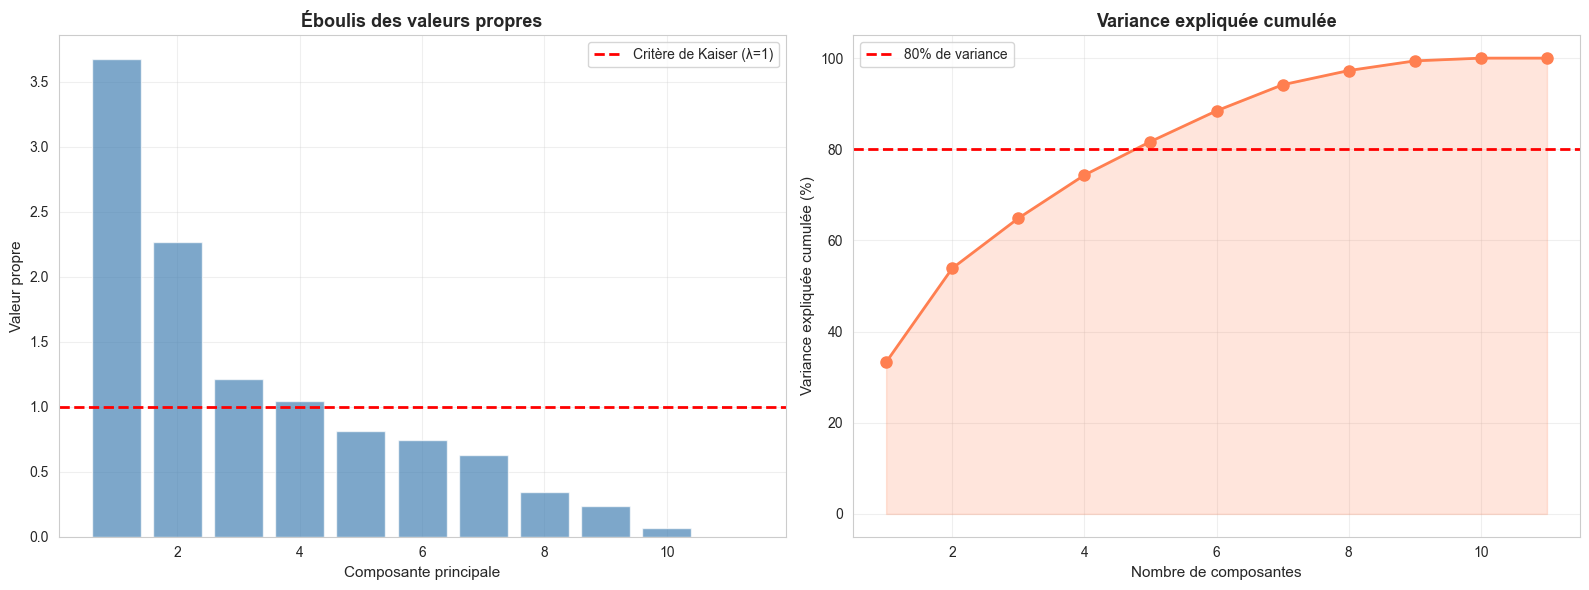

In [45]:
print("\n[6] VISUALISATION - ÉBOULIS DES VALEURS PROPRES")
print("-"*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique des valeurs propres
axes[0].bar(range(1, n_components + 1), eigenvalues, color='steelblue', alpha=0.7)
axes[0].axhline(y=1, color='red', linestyle='--', linewidth=2, label='Critère de Kaiser (λ=1)')
axes[0].set_xlabel('Composante principale', fontsize=11)
axes[0].set_ylabel('Valeur propre', fontsize=11)
axes[0].set_title('Éboulis des valeurs propres', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Variance cumulée
axes[1].plot(range(1, n_components + 1), variance_cumulee * 100, 
             marker='o', linewidth=2, markersize=8, color='coral')
axes[1].axhline(y=80, color='red', linestyle='--', linewidth=2, label='80% de variance')
axes[1].fill_between(range(1, n_components + 1), 0, variance_cumulee * 100, alpha=0.2, color='coral')
axes[1].set_xlabel('Nombre de composantes', fontsize=11)
axes[1].set_ylabel('Variance expliquée cumulée (%)', fontsize=11)
axes[1].set_title('Variance expliquée cumulée', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
output_path = "../visualisation/acp"
os.makedirs(output_path, exist_ok=True)

plt.savefig(f"{output_path}/acp_scree_plot.png", dpi=300, bbox_inches='tight')
print(f"✓ Éboulis des valeurs propres sauvegardé : {output_path}/acp_scree_plot.png")
plt.show()




# 7. CONTRIBUTIONS DES VARIABLES

In [46]:
print("\n[7] CONTRIBUTIONS DES VARIABLES AUX COMPOSANTES")
print("-"*80)

# Loadings (corrélations variables-composantes)
loadings = pca.components_.T * np.sqrt(eigenvalues)

# Créer un DataFrame pour les loadings
loadings_df = pd.DataFrame(
    loadings,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=variables_acp
)

print("\n7.1 Chargement des 3 premières composantes :")
print(loadings_df.iloc[:, :3].round(3))

# Contributions (en %)
contributions = (pca.components_.T ** 2) * 100
contributions_df = pd.DataFrame(
    contributions,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=variables_acp
)

print("\n7.2 Contributions des variables à PC1 (%) :")
contrib_pc1 = contributions_df['PC1'].sort_values(ascending=False)
print(contrib_pc1.round(2))

print("\n7.3 Contributions des variables à PC2 (%) :")
contrib_pc2 = contributions_df['PC2'].sort_values(ascending=False)
print(contrib_pc2.round(2))


[7] CONTRIBUTIONS DES VARIABLES AUX COMPOSANTES
--------------------------------------------------------------------------------

7.1 Chargement des 3 premières composantes :
                      PC1    PC2    PC3
Capacite            0.442 -0.209 -0.437
prix_billet_moyen   0.792  0.138 -0.289
temperature        -0.553 -0.248  0.342
Recette_Moyenne     0.830  0.181 -0.156
isDerby             0.778  0.207  0.577
is_important_match  0.011 -0.020  0.030
is_top_team_home    0.559 -0.447 -0.075
est_weekend        -0.427  0.826  0.055
mois               -0.322 -0.540  0.339
jour_semaine       -0.212  0.924 -0.079
derby_top_team      0.778  0.207  0.577

7.2 Contributions des variables à PC1 (%) :
Recette_Moyenne       18.76
prix_billet_moyen     17.10
isDerby               16.49
derby_top_team        16.49
is_top_team_home       8.52
temperature            8.31
Capacite               5.31
est_weekend            4.97
mois                   2.82
jour_semaine           1.22
is_important_match 

# 8. CERCLE DE CORRÉLATIONS (PC1 vs PC2)


[8] CERCLE DE CORRÉLATIONS
--------------------------------------------------------------------------------
✓ Cercle de corrélations sauvegardé : ../visualisation/acp/acp_correlation_circle.png


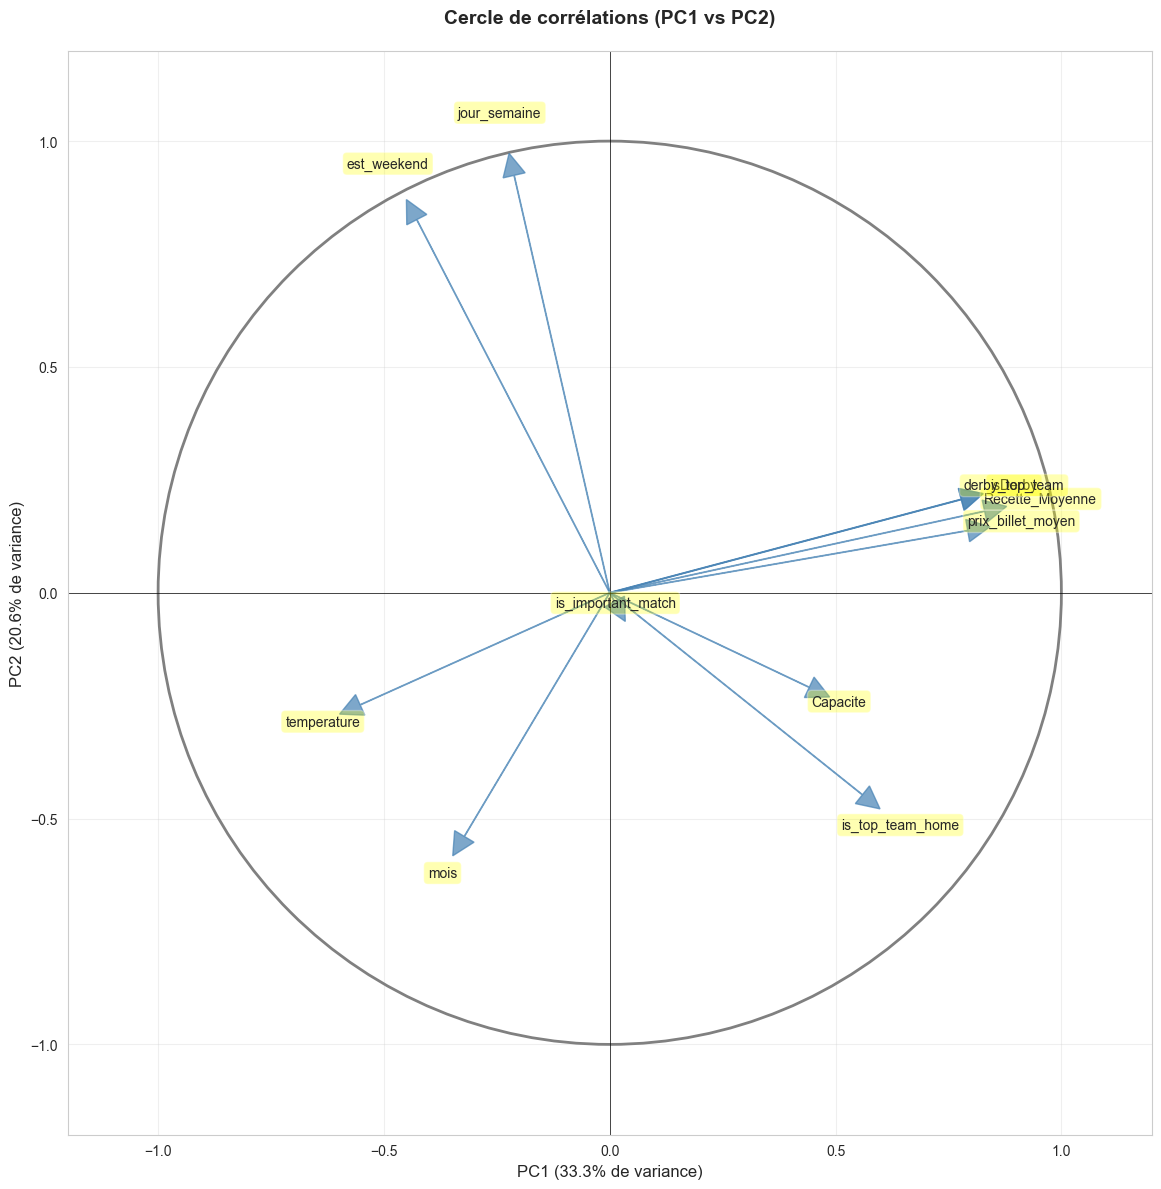

In [47]:
print("\n[8] CERCLE DE CORRÉLATIONS")
print("-"*80)

fig, ax = plt.subplots(figsize=(12, 12))

# Dessiner le cercle de corrélation
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linewidth=2)
ax.add_artist(circle)

# Tracer les vecteurs des variables
for i, var in enumerate(variables_acp):
    ax.arrow(0, 0, loadings[i, 0], loadings[i, 1],
             head_width=0.05, head_length=0.05, fc='steelblue', ec='steelblue', alpha=0.7)
    
    # Positionner les labels
    offset = 0.15
    ax.text(loadings[i, 0] * (1 + offset), loadings[i, 1] * (1 + offset),
            var, fontsize=10, ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# Configuration du graphique
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_xlabel(f'PC1 ({variance_expliquee[0]*100:.1f}% de variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({variance_expliquee[1]*100:.1f}% de variance)', fontsize=12)
ax.set_title('Cercle de corrélations (PC1 vs PC2)', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
output_path = "../visualisation/acp"
os.makedirs(output_path, exist_ok=True)

plt.savefig(f"{output_path}/acp_correlation_circle.png", dpi=300, bbox_inches='tight')
print(f"✓ Cercle de corrélations sauvegardé : {output_path}/acp_correlation_circle.png")
plt.show()


# 9. HEATMAP DES CONTRIBUTIONS


[9] HEATMAP DES CONTRIBUTIONS
--------------------------------------------------------------------------------
✓ Heatmap des contributions sauvegardée : ../visualisation/acp/acp_contributions_heatmap.png


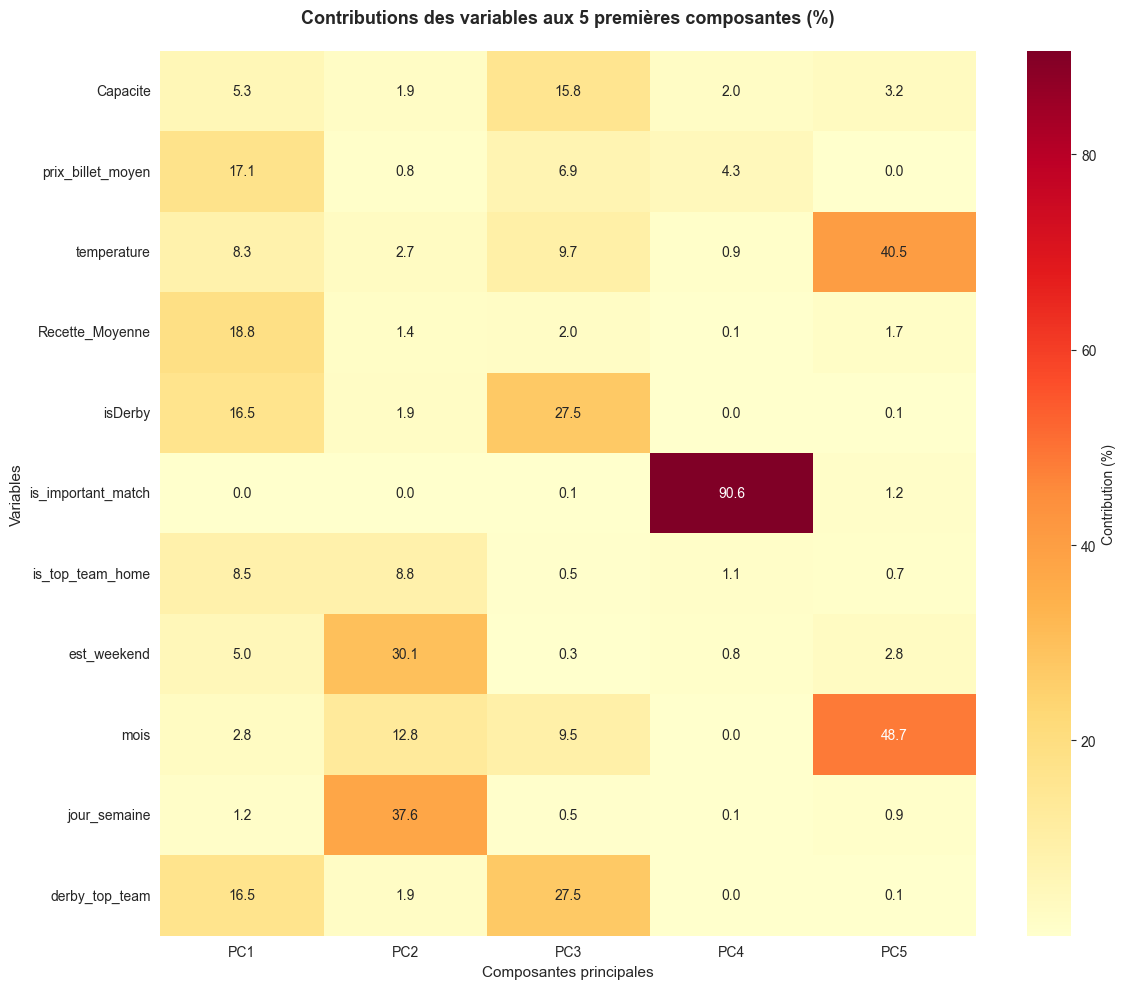

In [48]:
print("\n[9] HEATMAP DES CONTRIBUTIONS")
print("-"*80)

# Heatmap pour les 5 premières composantes
n_comp_viz = min(5, n_components)

fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(contributions_df.iloc[:, :n_comp_viz], 
            annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Contribution (%)'}, ax=ax)
ax.set_title(f'Contributions des variables aux {n_comp_viz} premières composantes (%)', 
             fontsize=13, fontweight='bold', pad=20)
ax.set_xlabel('Composantes principales', fontsize=11)
ax.set_ylabel('Variables', fontsize=11)

plt.tight_layout()
output_path = "../visualisation/acp"
os.makedirs(output_path, exist_ok=True)

plt.savefig(f"{output_path}/acp_contributions_heatmap.png", dpi=300, bbox_inches='tight')
print(f"✓ Heatmap des contributions sauvegardée : {output_path}/acp_contributions_heatmap.png")
plt.show()


# 10. BIPLOT (INDIVIDUS ET VARIABLES)


[10] BIPLOT (INDIVIDUS ET VARIABLES)
--------------------------------------------------------------------------------
✓ Biplot sauvegardé : ../visualisation/acp/acp_biplot.png


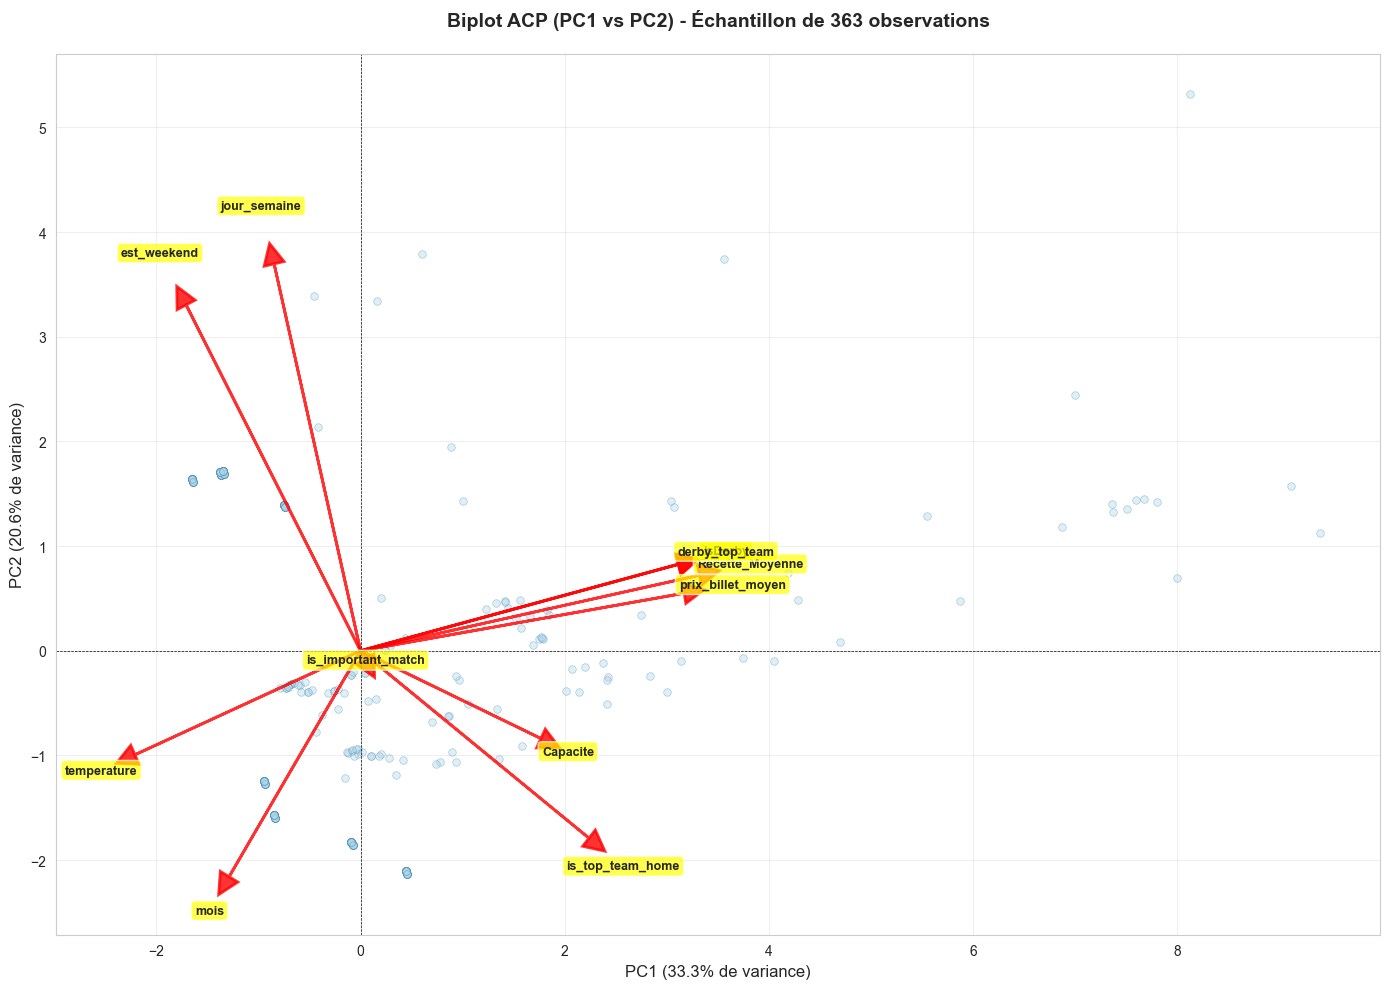

In [49]:
print("\n[10] BIPLOT (INDIVIDUS ET VARIABLES)")
print("-"*80)

# Échantillonnage pour la visualisation (max 500 points)
n_samples = min(500, len(components))
sample_idx = np.random.choice(len(components), n_samples, replace=False)

fig, ax = plt.subplots(figsize=(14, 10))

# Projection des individus (échantillonnés)
ax.scatter(components[sample_idx, 0], components[sample_idx, 1], 
           alpha=0.4, s=30, c='lightblue', edgecolors='steelblue', linewidth=0.5)

# Facteur d'échelle pour les vecteurs
scale = 4

# Tracer les vecteurs des variables
for i, var in enumerate(variables_acp):
    ax.arrow(0, 0, loadings[i, 0] * scale, loadings[i, 1] * scale,
             head_width=0.2, head_length=0.2, fc='red', ec='red', alpha=0.8, linewidth=2)
    
    ax.text(loadings[i, 0] * scale * 1.15, loadings[i, 1] * scale * 1.15,
            var, fontsize=9, ha='center', va='center', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.axhline(y=0, color='k', linewidth=0.5, linestyle='--')
ax.axvline(x=0, color='k', linewidth=0.5, linestyle='--')
ax.set_xlabel(f'PC1 ({variance_expliquee[0]*100:.1f}% de variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({variance_expliquee[1]*100:.1f}% de variance)', fontsize=12)
ax.set_title(f'Biplot ACP (PC1 vs PC2) - Échantillon de {n_samples} observations', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)


plt.tight_layout()
output_path = "../visualisation/acp"
os.makedirs(output_path, exist_ok=True)

plt.savefig(f"{output_path}/acp_biplot.png", dpi=300, bbox_inches='tight')
print(f"✓ Biplot sauvegardé : {output_path}/acp_biplot.png")
plt.show()

# 11. PROJECTION SUR PC1-PC2 PAR COMPÉTITION


[11] PROJECTION PAR COMPÉTITION
--------------------------------------------------------------------------------
✓ Projection par compétition sauvegardée : ../visualisation/acp/acp_projection_competition.png


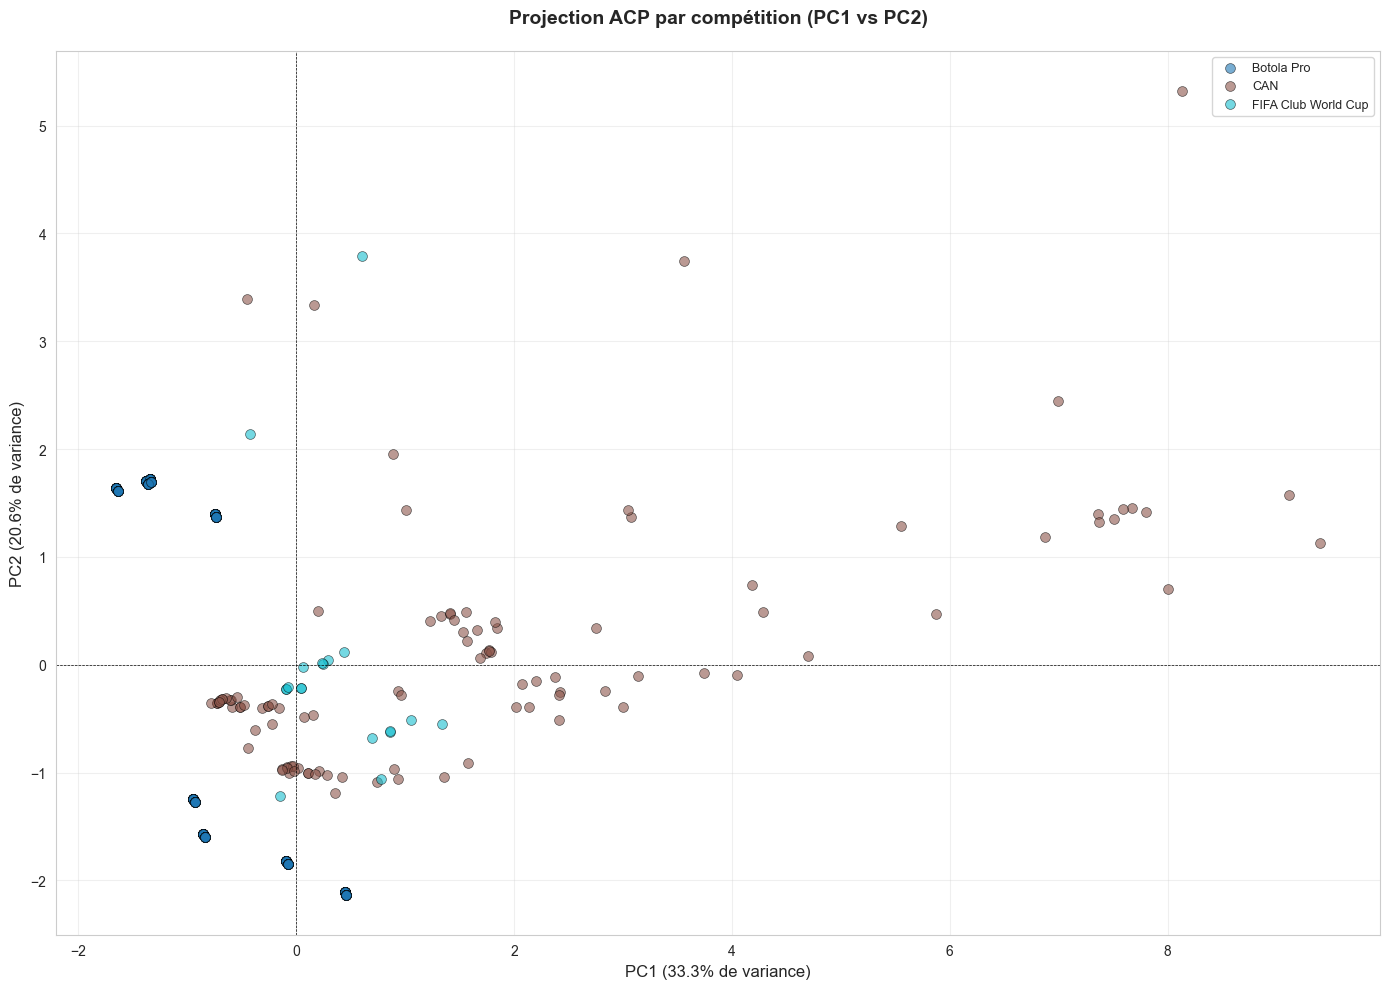

In [50]:
print("\n[11] PROJECTION PAR COMPÉTITION")
print("-"*80)

# Créer un DataFrame avec les composantes principales
components_df = pd.DataFrame(
    components[:, :3],
    columns=['PC1', 'PC2', 'PC3'],
    index=df.index
)
components_df['Competition'] = df['Competition'].values

fig, ax = plt.subplots(figsize=(14, 10))

# Couleurs pour chaque compétition
competitions = components_df['Competition'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(competitions)))

for comp, color in zip(competitions, colors):
    mask = components_df['Competition'] == comp
    ax.scatter(components_df.loc[mask, 'PC1'], 
               components_df.loc[mask, 'PC2'],
               label=comp, alpha=0.6, s=50, c=[color], edgecolors='black', linewidth=0.5)

ax.axhline(y=0, color='k', linewidth=0.5, linestyle='--')
ax.axvline(x=0, color='k', linewidth=0.5, linestyle='--')
ax.set_xlabel(f'PC1 ({variance_expliquee[0]*100:.1f}% de variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({variance_expliquee[1]*100:.1f}% de variance)', fontsize=12)
ax.set_title('Projection ACP par compétition (PC1 vs PC2)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
output_path = "../visualisation/acp"
os.makedirs(output_path, exist_ok=True)

plt.savefig(f"{output_path}/acp_projection_competition.png", dpi=300, bbox_inches='tight')
print(f"✓ Projection par compétition sauvegardée : {output_path}/acp_projection_competition.png")
plt.show()



# 12. INTERPRÉTATION DES COMPOSANTES PRINCIPALES

In [51]:
print("\n[12] INTERPRÉTATION DES COMPOSANTES PRINCIPALES")
print("-"*80)

def interpreter_composante(comp_num, top_n=5):
    """Interprète une composante en identifiant les variables les plus contributives"""
    contrib = contributions_df[f'PC{comp_num}'].sort_values(ascending=False)
    loading = loadings_df[f'PC{comp_num}']
    
    print(f"\nPC{comp_num} - Variance expliquée : {variance_expliquee[comp_num-1]*100:.2f}%")
    print("-" * 60)
    print(f"Variables les plus contributives (top {top_n}) :")
    
    for i, (var, contrib_val) in enumerate(contrib.head(top_n).items(), 1):
        loading_val = loading[var]
        direction = "positivement" if loading_val > 0 else "négativement"
        print(f"  {i}. {var:25} : {contrib_val:6.2f}% (corrélation : {loading_val:+.3f}, {direction})")
    
    return contrib.head(top_n)

print("\n=== INTERPRÉTATION DES 3 PREMIÈRES COMPOSANTES ===")

# PC1
top_pc1 = interpreter_composante(1, top_n=5)

# PC2
top_pc2 = interpreter_composante(2, top_n=5)

# PC3
top_pc3 = interpreter_composante(3, top_n=5)



[12] INTERPRÉTATION DES COMPOSANTES PRINCIPALES
--------------------------------------------------------------------------------

=== INTERPRÉTATION DES 3 PREMIÈRES COMPOSANTES ===

PC1 - Variance expliquée : 33.30%
------------------------------------------------------------
Variables les plus contributives (top 5) :
  1. Recette_Moyenne           :  18.76% (corrélation : +0.830, positivement)
  2. prix_billet_moyen         :  17.10% (corrélation : +0.792, positivement)
  3. isDerby                   :  16.49% (corrélation : +0.778, positivement)
  4. derby_top_team            :  16.49% (corrélation : +0.778, positivement)
  5. is_top_team_home          :   8.52% (corrélation : +0.559, positivement)

PC2 - Variance expliquée : 20.58%
------------------------------------------------------------
Variables les plus contributives (top 5) :
  1. jour_semaine              :  37.62% (corrélation : +0.924, positivement)
  2. est_weekend               :  30.06% (corrélation : +0.826, positive

# 13. SAUVEGARDE DES COMPOSANTES PRINCIPALES

In [52]:
print("\n[13] SAUVEGARDE DES COMPOSANTES PRINCIPALES")
print("-"*80)

# Créer un DataFrame complet avec les composantes
df_with_pca = df.copy()

# Ajouter les composantes principales (toutes)
for i in range(n_components):
    df_with_pca[f'PC{i+1}'] = components[:, i]

# Sauvegarder
output_file = '../data/pca/data_with_pca.csv'
df_with_pca.to_csv(output_file, index=False, encoding='utf-8')
print(f"✓ Données avec composantes principales sauvegardées : {output_file}")

# Sauvegarder les loadings et contributions
loadings_df.to_csv('../data/pca/pca_loadings.csv', encoding='utf-8')
print("✓ Loadings sauvegardés : ../data/pca/pca_loadings.csv")

contributions_df.to_csv('../data/pca/pca_contributions.csv', encoding='utf-8')
print("✓ Contributions sauvegardées : ../data/pca/pca_contributions.csv")


[13] SAUVEGARDE DES COMPOSANTES PRINCIPALES
--------------------------------------------------------------------------------
✓ Données avec composantes principales sauvegardées : ../data/pca/data_with_pca.csv
✓ Loadings sauvegardés : ../data/pca/pca_loadings.csv
✓ Contributions sauvegardées : ../data/pca/pca_contributions.csv


# 14. RAPPORT DE SYNTHÈSE ACP

In [ ]:
print("\n[14] GÉNÉRATION DU RAPPORT DE SYNTHÈSE")
print("-"*80)

rapport = f"""
RAPPORT D'ANALYSE EN COMPOSANTES PRINCIPALES (ACP)
===================================================

1. CONFIGURATION
   - Nombre de variables : {n_components}
   - Nombre d'observations : {len(df)}
   - Méthode de standardisation : Centrage-réduction (StandardScaler)

2. VARIANCE EXPLIQUÉE
   - PC1 : {variance_expliquee[0]*100:.2f}%
   - PC2 : {variance_expliquee[1]*100:.2f}%
   - PC3 : {variance_expliquee[2]*100:.2f}%
   - Variance cumulée PC1+PC2 : {variance_cumulee[1]*100:.2f}%
   - Variance cumulée PC1+PC2+PC3 : {variance_cumulee[2]*100:.2f}%

3. CRITÈRES DE SÉLECTION
   - Critère de Kaiser (λ > 1) : {sum(eigenvalues > 1)} composantes
   - Critère des 80% : {n_comp_80} composantes
   - Recommandation : Utiliser {max(sum(eigenvalues > 1), 3)} composantes

4. INTERPRÉTATION PC1 ({variance_expliquee[0]*100:.2f}%)
   Variables principales :
   {chr(10).join([f"   - {var} : {val:.1f}%" for var, val in top_pc1.items()])}

5. INTERPRÉTATION PC2 ({variance_expliquee[1]*100:.2f}%)
   Variables principales :
   {chr(10).join([f"   - {var} : {val:.1f}%" for var, val in top_pc2.items()])}

6. INTERPRÉTATION PC3 ({variance_expliquee[2]*100:.2f}%)
   Variables principales :
   {chr(10).join([f"   - {var} : {val:.1f}%" for var, val in top_pc3.items()])}

7. RECOMMANDATIONS POUR LA MODÉLISATION
   - L'ACP révèle {sum(eigenvalues > 1)} dimensions principales dans les données
   - Les {n_comp_80} premières composantes capturent {variance_cumulee[n_comp_80-1]*100:.1f}% de la variance
   - Options pour la régression :
     a) Utiliser les variables originales (interprétabilité)
     b) Utiliser les composantes principales (réduction dimensionnelle)
     c) Approche hybride : variables principales de chaque PC

8. FICHIERS GÉNÉRÉS
   - data/pca/data_with_pca.csv (données + composantes)
   - data/pca/pca_loadings.csv (corrélations variables-composantes)
   - data/pca/pca_contributions.csv (contributions en %)
   - Visualisations : 5 graphiques PNG

Date : {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

with open('../rapport/rapport_acp.txt', 'w', encoding='utf-8') as f:
    f.write(rapport)

print("✓ Rapport ACP sauvegardé : ../rapport/rapport_acp.txt")

print("\n" + "="*80)
print("ANALYSE EN COMPOSANTES PRINCIPALES TERMINÉE AVEC SUCCÈS !")
print("="*80)
print(f"\nFichiers générés :")
print(f"  1. virtualisation/pca/acp_scree_plot.png")
print(f"  2. virtualisation/pca/acp_correlation_circle.png")
print(f"  3. virtualisation/pca/acp_contributions_heatmap.png")
print(f"  4. virtualisation/pca/acp_biplot.png")
print(f"  5. virtualisation/pca/acp_projection_competition.png")
print(f"  6. data/pca/data_with_pca.csv")
print(f"  7. data/pca/pca_loadings.csv")
print(f"  8. data/pca/pca_contributions.csv")
print(f"  9. rapport/rapport_acp.txt")
print("\nProchaine étape : Notebook 4 - Régression Linéaire Multivariée")


[14] GÉNÉRATION DU RAPPORT DE SYNTHÈSE
--------------------------------------------------------------------------------
✓ Rapport ACP sauvegardé : data/pca/rapport_acp.txt

ANALYSE EN COMPOSANTES PRINCIPALES TERMINÉE AVEC SUCCÈS !

Fichiers générés :
  1. virtualisation/pca/acp_scree_plot.png
  2. virtualisation/pca/acp_correlation_circle.png
  3. virtualisation/pca/acp_contributions_heatmap.png
  4. virtualisation/pca/acp_biplot.png
  5. virtualisation/pca/acp_projection_competition.png
  6. data/pca/data_with_pca.csv
  7. data/pca/pca_loadings.csv
  8. data/pca/pca_contributions.csv
  9. data/pca/rapport_acp.txt

Prochaine étape : Notebook 4 - Régression Linéaire Multivariée
